In [34]:
import pandas as pd
from utils.evaluation import FBQA_Dataset, MetaQA_Dataset

In [35]:
fbqa = FBQA_Dataset()
fbqa_stats = fbqa.tabulate_performance()

FBQA
+----------+------------+
| Method   |   Test Set |
+==========+============+
| bline    |   0.736486 |
+----------+------------+
| bline2   |   0.737738 |
+----------+------------+
| kb1      |   0.635886 |
+----------+------------+


KB performance is quite poor,
I would suppose that is due to:
1) over saturation with information, I had limit the number of triplets to 600 to avoid running out of memory
2) the triplets provided are 1hop away, whereas most questions have a long inference chain

TODO:
- investigate #hops/accuracy relationship for bline and kb1

In [36]:
metaqa = MetaQA_Dataset()
metaqa.tabulate_performance()

MetaQA
+----------+----------+----------+----------+
| Method   |     1hop |     2hop |     3hop |
+==========+==========+==========+==========+
| bline    | 0.390168 | 0.231509 | 0.418103 |
+----------+----------+----------+----------+
| bline2   | 0.394591 | 0.232316 | 0.415861 |
+----------+----------+----------+----------+
| kb1      | 0.862371 | 0.175632 | 0.34202  |
+----------+----------+----------+----------+


TODO:
1. Make the search less static
2. Address the size issue (neighbour order = size explosion)

Potentially:
1. Do RAG
2. Rerank Chunks
2. From the top chunks, extract triplets and continue

Project Structure:
1. Baseline (have a stable vanilla answer)
2. KG integration (shown the improvement)
3. Constructing the KB (how to quantify construction performance)
4. Using the KB (dynamic exploration)

## FBQA hop accuracy exploration

In [71]:
fbqa_tset = fbqa.test_set.copy()
fbqa_tset["Answer"] = fbqa.answers
fbqa_tset["hops"] = fbqa_tset.Questions.apply(lambda t: len(t["Parses"][0]["InferentialChain"].split(".")))
fbqa_tset.drop(columns=["Dataset", "Version", "Questions"], inplace=True)
fbqa_tset.head()

,Answer,hops
0,sandi toksvig,7
1,henry fonda,3
2,terry gilliam,3
3,steve mcqueen,3
4,harold abrahams,7


[ 7  3  5  9 13  4  8 11]


<Axes: >

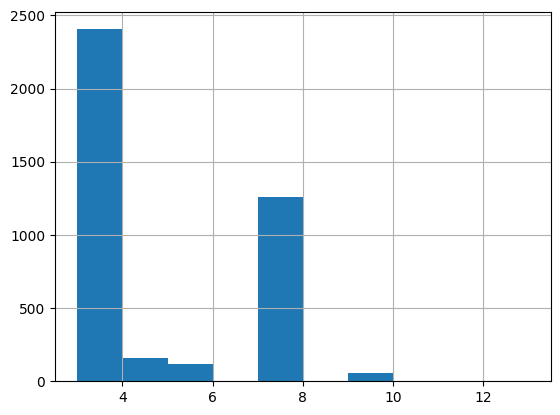

In [60]:
print(fbqa_tset.hops.unique())
fbqa_tset.hops.hist()

In [81]:
# load model answers
for r_set in fbqa.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    result_df = pd.read_csv(r_set)
    fbqa_tset[set_name] = result_df.Model.apply(str.lower)
    fbqa_tset[f"{set_name}_correct"] = fbqa_tset.apply(lambda t: t.Answer in t[set_name], axis=1)
fbqa_tset.head()

,Answer,hops,bline,bline2,kb1,bline_correct,bline2_correct,kb1_correct
0,sandi toksvig,7,anita rani,anna richardson,anna richardson,False,False,False
1,henry fonda,3,mervyn leroy produced the film 12 angry men.,mervyn leroy produced the film 12 angry men.,sidney lumet,False,False,False
2,terry gilliam,3,terry gilliam,terry gilliam,terri gilliam,True,True,False
3,steve mcqueen,3,steve mcqueen,steve mcqueen,steve mcqueen did not direct the 2013 film 12 ...,True,True,True
4,harold abrahams,7,harold abrahams,harold abrahams,harold abrahams,True,True,True


In [87]:
fbqa_res = fbqa_tset[["hops", "bline_correct", "bline2_correct", "kb1_correct"]]
fbqa_res.head()

,hops,bline_correct,bline2_correct,kb1_correct
0,7,False,False,False
1,3,False,False,False
2,3,True,True,False
3,3,True,True,True
4,7,True,True,True


In [116]:
hop_stats = fbqa_res.groupby(by="hops").sum()
hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))
for rset in ["bline", "bline2",	"kb1"]:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_correct"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_415/836395610.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))


,bline_correct,bline2_correct,kb1_correct,total,bline_p,bline2_p,kb1_p
hops,,,,,,,
3,1809,1817,1581,2405,0.752,0.756,0.657
4,118,121,111,157,0.752,0.771,0.707
5,92,94,80,115,0.800,0.817,0.696
7,880,871,737,1258,0.700,0.692,0.586
8,1,1,1,1,1.000,1.000,1.000
9,41,42,30,56,0.732,0.750,0.536
11,1,1,1,1,1.000,1.000,1.000
13,1,1,0,3,0.333,0.333,0.000


In [119]:
print("FBQA")
hop_stats[["bline_p", "bline2_p", "kb1_p", "total"]]

FBQA


,bline_p,bline2_p,kb1_p,total
hops,,,,
3,0.752,0.756,0.657,2405
4,0.752,0.771,0.707,157
5,0.800,0.817,0.696,115
7,0.700,0.692,0.586,1258
8,1.000,1.000,1.000,1
9,0.732,0.750,0.536,56
11,1.000,1.000,1.000,1
13,0.333,0.333,0.000,3
